In [1]:
using DelimitedFiles
using Gadfly, Cairo, Colors
using LinearAlgebra
using Statistics

set_default_plot_size(15cm,13cm)
color_palette = Scale.color_discrete().f(7)[[1, 4, 6]]                                      
themes = [Theme(default_color=color, panel_fill="white", grid_color="lightgray",            
                background_color=parse(Colorant, "white")) for color in color_palette];

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /home/cokes/.julia/packages/Compose/Nd7mL/src/Compose.jl:162
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:837


load raw point cloud data. tranpose it so that the points are in the columns of `B`. not necessary, but, subtract off mean to center the point cloud.

In [2]:
B = readdlm("point_cloud.txt")

2×70 Array{Float64,2}:
 0.0665881  0.0254488  -0.0160557  …   0.60139    0.59655    0.589601 
 0.146241   0.167605    0.210247      -0.0059604  0.0259648  0.0557668

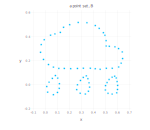

In [3]:
p = plot(x=B[1, :], y=B[2, :], Geom.point, themes[1],
         Guide.title("a point set, B"), themes[1],
         Coord.cartesian(fixed=true),
    )

In [4]:
draw(PNG("ptset_B.png", 5inch, 4inch, dpi=300), p)

rotate each point in `B` about the origin by an angle `θ` via multiplying by a rotation matrix `R_known`. then add some Gaussian noise to each point. this forms the point cloud `A`.

In [5]:
rotation_matrix2d(θ::Float64) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

rotation_matrix2d (generic function with 1 method)

In [6]:
θ = π * 0.8
R_known = rotation_matrix2d(θ)

2×2 Array{Float64,2}:
 -0.809017  -0.587785
  0.587785  -0.809017

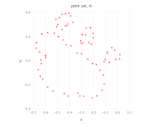

In [7]:
ϵ = 0.01 # noise
A = R_known * B .+ ϵ * randn(size(B)...)

p = plot(x=A[1, :], y=A[2, :], Geom.point, themes[3],
         Guide.title("point set, A"), themes[3],
         Coord.cartesian(fixed=true),
    )

In [8]:
draw(PNG("ptset_A.png", 5inch, 4inch, dpi=300), p)

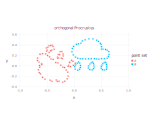

In [9]:
p = plot(layer(x=A[1, :], y=A[2, :], Geom.point, themes[3]),                            
         layer(x=B[1, :], y=B[2, :], Geom.point, themes[1]),    
         Guide.title("orthogonal Procrustes"), themes[1],
         Coord.cartesian(fixed=true),
         Guide.manual_color_key("point set", ["A", "B"], [color_palette[3], color_palette[1]])
    )  

In [10]:
draw(PNG("before_alignment.png", 5inch, 4inch, dpi=300), p)

highlight that we know the correspondence between the points in `A` and the points in `B` by connecting corresponding points with a gray line.

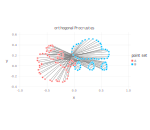

In [11]:
p = plot(layer(x=A[1, :], y=A[2, :], Geom.point, themes[3]),                            
         layer(x=B[1, :], y=B[2, :], Geom.point, themes[1]),
         [layer(x=[A[1, i], B[1, i]], y=[A[2, i], B[2, i]], 
            Geom.line, Theme(default_color=colorant"gray")) for i = 1:size(A)[2]]...,
         Guide.title("orthogonal Procrustes"), themes[1],
         Coord.cartesian(fixed=true),
         Guide.manual_color_key("point set", ["A", "B"], [color_palette[3], color_palette[1]])
    )  

In [12]:
draw(PNG("correspondence.png", 5inch, 4inch, dpi=300), p)

compute the singular value decomposition of $AB^T=U\Sigma V^T$.

In [13]:
F = svd(A * B')

SVD{Float64,Float64,Array{Float64,2}}([-0.966515 0.25661; 0.25661 0.966515], [12.0584, 2.50819], [0.932063 0.362297; 0.362297 -0.932063])

we can recover the orthogonal matrix `R` such that, when applied to `A`, the points in `RA` are close to the corresponding points in `B`, as $R = VU^T$.

In [14]:
R = F.V * F.U'

2×2 Array{Float64,2}:
 -0.807883   0.589343
 -0.589343  -0.807883

In [15]:
isapprox(R, rotation_matrix2d(-θ), rtol=0.01)

true

In [16]:
A_transformed = R * A

2×70 Array{Float64,2}:
 0.071721  0.0233413  -0.0247726  …   0.60124     0.616662   0.579418 
 0.150201  0.166261    0.222595      -0.00331735  0.0243698  0.0488839

voila

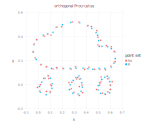

In [17]:
p = plot(layer(x=A_transformed[1, :], y=A_transformed[2, :], Geom.point, themes[3]),                            
         layer(x=B[1, :], y=B[2, :], Geom.point, themes[1]),    
         Guide.title("orthogonal Procrustes"), themes[1],
         Coord.cartesian(fixed=true),
         Guide.manual_color_key("point set", ["RA", "B"], [color_palette[3], color_palette[1]])
    ) 

In [19]:
draw(PNG("after_alignment.png", 5inch, 4inch, dpi=300), p)